<a href="https://colab.research.google.com/github/ehcdc1967/Proyectos-de-Inversion/blob/main/modelo_xgboost_con_gridsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# 1. Carga de datos
df = pd.read_parquet('https://raw.githubusercontent.com/ehcdc1967/Proyectos-de-Inversion/main/poblacion.parquet')

In [ ]:
# 2. Limpieza de datos
df.drop(columns=['CODIGO_UNICO','RATIO_ET_VIABLE','RATIO_ET_COSTO'], inplace=True, errors='ignore')  # Eliminar columnas irrelevantes

In [ ]:
# Identificar columnas categóricas
columns_to_encode = [col for col in ['FUNCION', 'DPTO', 'TIPO_MUNICIPALIDAD'] if col in df.columns]

# Crea una columna nueva para cada valor distinto de cada columna categórica.
if columns_to_encode:
    df[columns_to_encode] = df[columns_to_encode].astype(str).fillna('Unknown')
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

In [ ]:
# Verificar si la variable objetivo está presente
if 'SOBRECOSTO' not in df.columns:
    raise ValueError("La columna objetivo 'SOBRECOSTO' no está en el conjunto de datos.")

In [ ]:
# Separar características y variable objetivo
X, y = df.drop(columns=['SOBRECOSTO']), df['SOBRECOSTO']

In [ ]:
# 3. Normalización con MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# 4. Configuración de validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [ ]:
# 5. Función para evaluar el modelo
def evaluar_modelo(modelo, X, y, descripcion):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results = cross_validate(modelo, X, y, scoring=scoring, cv=kf, return_train_score=False)

    resultados = {metrica: abs(np.mean(cv_results[f'test_{metrica}'])) for metrica in scoring}

    print(f"\n=== Resultados {descripcion} ===")
    for metrica, valor in resultados.items():
        print(f"{metrica.capitalize()} promedio: {valor:.4f}")

    return resultados

In [ ]:
# 6. Entrenamiento del modelo XGBoost con datos desbalanceados
modelo_desbalanceado = XGBClassifier(
     random_state     = 2024
    ,eval_metric      ='logloss'
    ,scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]  # Balanceo interno
    ,learning_rate    = 0.1
    ,n_estimators     = 100
    ,max_depth        = 4
    )

modelo_desbalanceado.fit(X, y)

resultados_desbalanceado = evaluar_modelo(modelo_desbalanceado, X, y, "Modelo Desbalanceado")



=== Resultados Modelo Desbalanceado ===
Accuracy promedio: 0.8432
Precision promedio: 0.6505
Recall promedio: 0.8331
F1 promedio: 0.7306


In [ ]:
# 7. Balanceo de datos con SMOTE
X_balanced, y_balanced = SMOTE(random_state=2024).fit_resample(X, y)

In [ ]:
# 8. Entrenamiento del modelo XGBoost con datos balanceados
modelo_balanceado = XGBClassifier(
     random_state  = 2024
    ,eval_metric   = 'logloss'
    ,learning_rate = 0.1
    ,n_estimators  = 100
    ,max_depth     = 4
    )

modelo_balanceado.fit(X_balanced, y_balanced)

resultados_balanceado = evaluar_modelo(modelo_balanceado, X_balanced, y_balanced, "Modelo Balanceado")


=== Resultados Modelo Balanceado ===
Accuracy promedio: 0.8770
Precision promedio: 0.8576
Recall promedio: 0.9041
F1 promedio: 0.8802


In [ ]:
# 9. Comparación de Importancia de Variables

importances_desbalanceado = modelo_desbalanceado.feature_importances_

importances_balanceado = modelo_balanceado.feature_importances_

feature_names = df.drop(columns=['SOBRECOSTO']).columns

# Convertir a DataFrame para mejor visualización
feature_importance_df = pd.DataFrame({
     'Variable'                 : feature_names
    ,'Importancia Desbalanceado': importances_desbalanceado
    ,'Importancia Balanceado'   : importances_balanceado
    })

# Ordenar por importancia en el modelo desbalanceado y seleccionar las 20 variables más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia Desbalanceado', ascending=False).head(20)

In [ ]:
# 10. Gráfico de comparación de métricas (accuracy, precision, recall, f1) con valores en negrita sobre las barras

# métricas de validación
metricas = ['accuracy', 'precision', 'recall', 'f1']

# Convertir a porcentaje
desbalanceado_vals = [resultados_desbalanceado[m] * 100 for m in metricas]

# Convertir a porcentaje
balanceado_vals = [resultados_balanceado[m] * 100 for m in metricas]

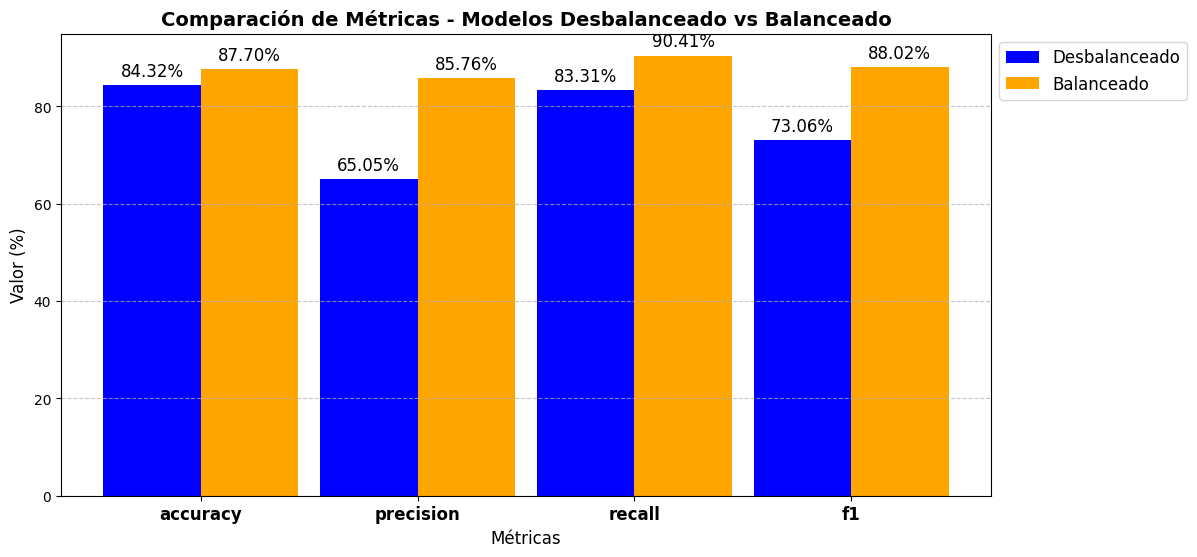

In [ ]:
# Generar nuevamente el gráfico con la leyenda a un costado y etiquetas más grandes y en negrita

fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(metricas))
width = 0.45
bars1 = ax.bar(x - width/2, desbalanceado_vals, width, label='Desbalanceado', color='blue')
bars2 = ax.bar(x + width/2, balanceado_vals, width, label='Balanceado', color='orange')
ax.set_xlabel('Métricas', fontsize=12 , ) # fontweight='bold'
ax.set_ylabel('Valor (%)', fontsize=12, ) # fontweight='bold'
ax.set_title('Comparación de Métricas - Modelos Desbalanceado vs Balanceado', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=0, fontsize=12, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
# Agregar valores en porcentaje sobre las barras en negrita y más grandes
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{bar.get_height():.2f}%",
            ha='center', va='bottom', fontsize=12, color='black')# , fontweight='bold'
plt.show()

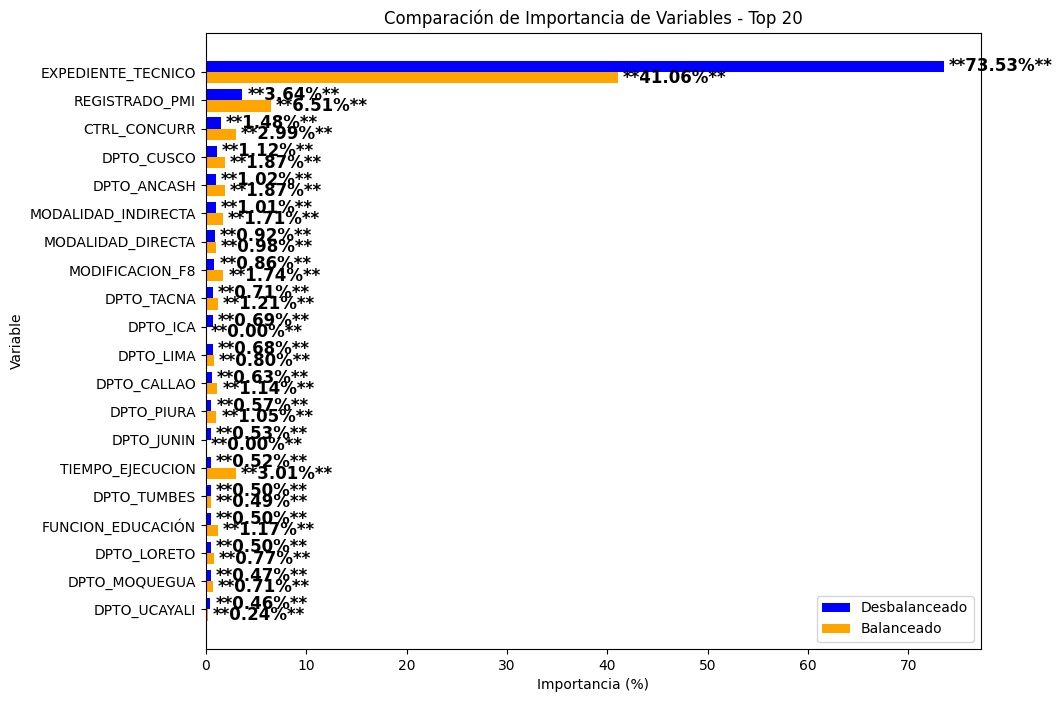

In [ ]:
# 11. Gráfico de comparación de importancia de variables (Top 20) con valores en negrita sobre las barras
fig, ax = plt.subplots(figsize=(10, 8))
x = np.arange(len(feature_importance_df))

bars1 = ax.barh(x - 0.2, feature_importance_df['Importancia Desbalanceado'] * 100, 0.4, label='Desbalanceado', color='blue')
bars2 = ax.barh(x + 0.2, feature_importance_df['Importancia Balanceado'] * 100, 0.4, label='Balanceado', color='orange')

ax.set_xlabel("Importancia (%)")
ax.set_ylabel("Variable")
ax.set_title("Comparación de Importancia de Variables - Top 20")
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'])
ax.invert_yaxis()  # La variable más importante arriba
ax.legend()

# Agregar valores en las barras con negrita
for bar in bars1 + bars2:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"**{bar.get_width():.2f}%**",
            ha='left', va='center', fontsize=12, fontweight='bold', color='black')

plt.show()

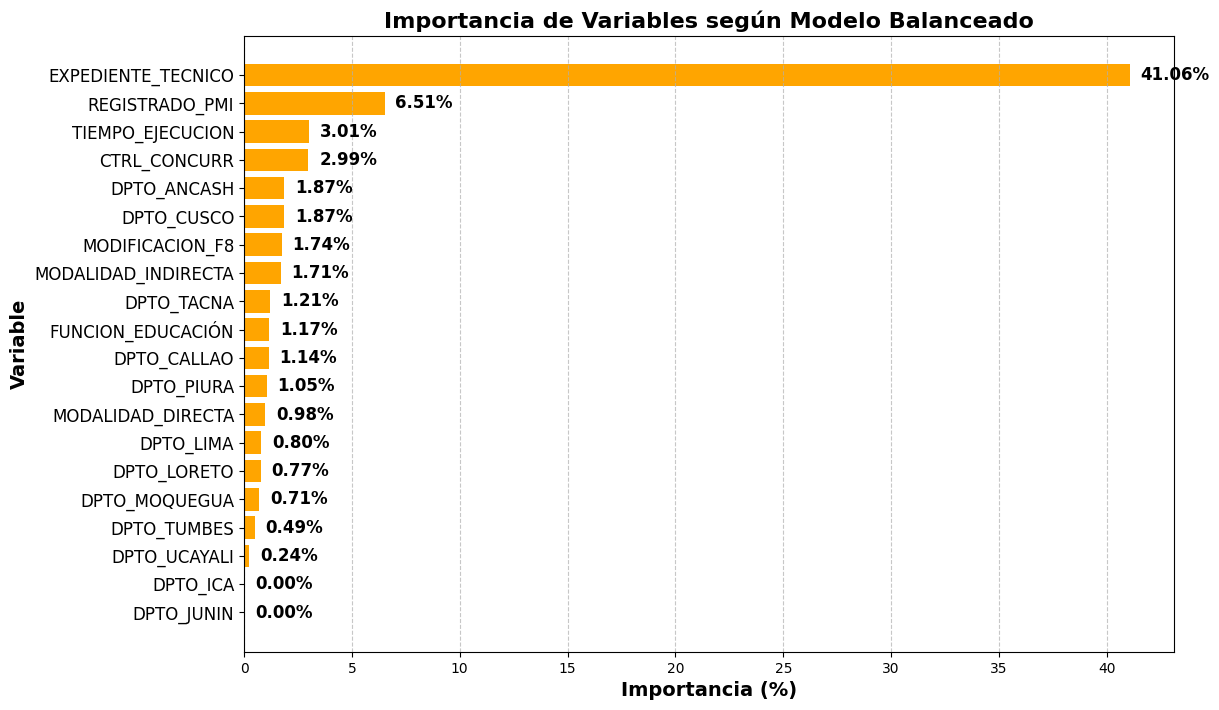

In [ ]:
# 12. Gráfico de importancia de variables (Top 20) con valores en negrita sobre las barras
# Mejorar el gráfico de importancia de variables (Top 20) del modelo balanceado
feature_importance_df = feature_importance_df.sort_values(by='Importancia Balanceado', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(feature_importance_df))
bars = ax.barh(x, feature_importance_df['Importancia Balanceado'] * 100, color='orange', label='Modelo Balanceado')
# Mejorar etiquetas y título
ax.set_xlabel("Importancia (%)", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Variable", fontsize=14, fontweight='bold', color='black')
ax.set_title("Importancia de Variables según Modelo Balanceado", fontsize=16, fontweight='bold', color='black')
# Ajustar etiquetas del eje Y
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'], fontsize=12)
# ax.invert_yaxis()  # Colocar la variable más importante arriba
# ax.legend(loc='upper right', fontsize=12)
# Agregar valores sobre las barras con negrita y mayor tamaño
for bar in bars:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}%",
            ha='left', va='center', fontsize=12, fontweight='bold', color='black')
# Agregar grid sutil para mejor visualización
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Agregar la optimización del modelo XGBoost balanceado mediante GridSearchCV

from sklearn.model_selection import GridSearchCV

# Definir la grilla de hiperparámetros para XGBoost
param_grid = {
     'n_estimators'    : [100,200,300]
    ,'max_depth'       : [3,4,5]
    ,'learning_rate'   : [0.01,0.1,0.2]
    ,'subsample'       : [0.8,1.0]
    ,'colsample_bytree': [0.8,1.0]
    ,'gamma'           : [0,0.1,0.2]
    }

In [ ]:
# Crear el clasificador base
modelo_xgb = XGBClassifier(random_state=2024, eval_metric='logloss')

# Aplicar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(modelo_xgb, param_grid, cv=kf, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_balanced, y_balanced)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2024, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importa...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=2024, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [ ]:
# Obtener el mejor modelo optimizado
mejor_modelo_balanceado = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# Evaluación del mejor modelo balanceado optimizado
resultados_optimizado = evaluar_modelo(mejor_modelo_balanceado, X_balanced, y_balanced, "Modelo Balanceado Optimizado")



=== Resultados Modelo Balanceado Optimizado ===
Accuracy promedio: 0.8937
Precision promedio: 0.8767
Recall promedio: 0.9163
F1 promedio: 0.8960


In [ ]:
# Comparación de métricas entre modelo balanceado y modelo balanceado optimizado
metricas = ['accuracy', 'precision', 'recall', 'f1']
valores_balanceado = [resultados_balanceado[m] * 100 for m in metricas]
valores_optimizado = [resultados_optimizado[m] * 100 for m in metricas]

x = np.arange(len(metricas))  # Posición de las métricas

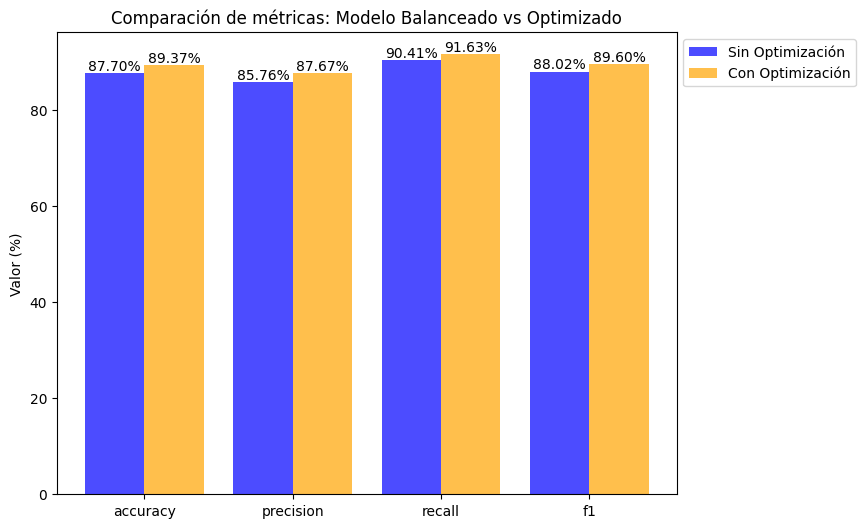

In [ ]:
# Crear el gráfico de comparación de métricas con valores sobre las barras
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - 0.2, valores_balanceado, width=0.4, label='Sin Optimización', color='blue', alpha=0.7)
bars2 = plt.bar(x + 0.2, valores_optimizado, width=0.4, label='Con Optimización', color='orange', alpha=0.7)

# Agregar los valores sobre las barras
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Configurar etiquetas y título
plt.xticks(ticks=x, labels=metricas)
plt.ylabel("Valor (%)")
plt.title("Comparación de métricas: Modelo Balanceado vs Optimizado")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# Mostrar el gráfico
plt.show()

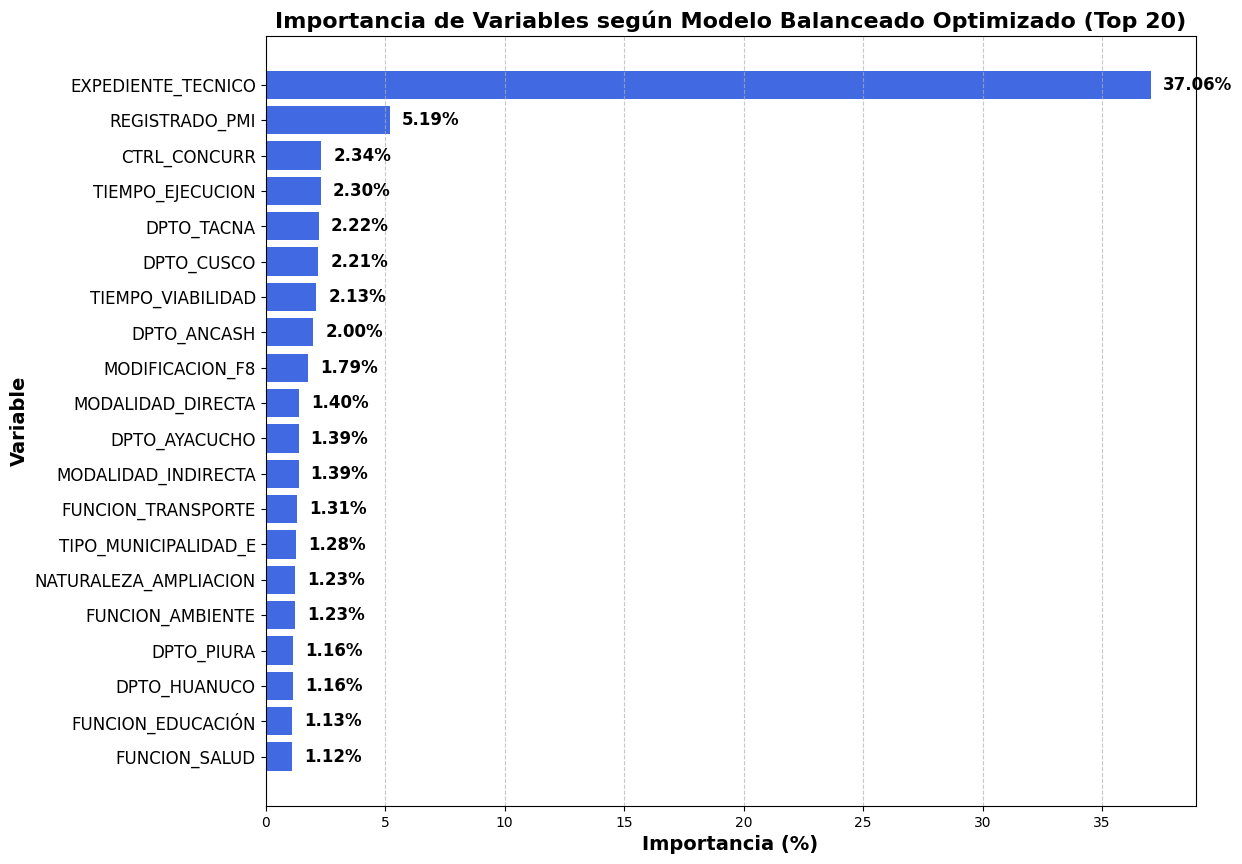

In [ ]:
# Generar el gráfico de importancia de variables para el mejor modelo optimizado
importances_optimizado = mejor_modelo_balanceado.feature_importances_
feature_names = df.drop(columns=['SOBRECOSTO']).columns
# Crear DataFrame con las importancias
feature_importance_df = pd.DataFrame({
     'Variable'   : feature_names
    ,'Importancia': importances_optimizado
     })
# Ordenar las variables por importancia y seleccionar las 20 más importantes
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False).head(20)
# Crear gráfico de importancia de variables del modelo optimizado
fig, ax = plt.subplots(figsize=(12, 10))
x = np.arange(len(feature_importance_df))
bars = ax.barh(x, feature_importance_df['Importancia'] * 100, color='royalblue', label='Modelo Balanceado Optimizado')
# Etiquetas y títulos mejorados
ax.set_xlabel("Importancia (%)", fontsize=14, fontweight='bold', color='black')
ax.set_ylabel("Variable", fontsize=14, fontweight='bold', color='black')
ax.set_title("Importancia de Variables según Modelo Balanceado Optimizado (Top 20)", fontsize=16, fontweight='bold', color='black')
# Ajustar etiquetas del eje Y
ax.set_yticks(x)
ax.set_yticklabels(feature_importance_df['Variable'], fontsize=12)
# Invertir eje Y para que la variable más importante esté arriba
ax.invert_yaxis()
# Agregar valores en las barras con negrita
for bar in bars:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{bar.get_width():.2f}%",
            ha='left', va='center', fontsize=12, fontweight='bold', color='black')
# Agregar una cuadrícula ligera en el eje X para mejor visualización
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
# Agregar leyenda
# ax.legend(loc='upper right', fontsize=12)
# Mostrar el gráfico
plt.show()